# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor

## import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from datetime import datetime, timedelta
%matplotlib inline

import os

In [2]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
for dirname, _, filenames in os.walk('/kaggle_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [3]:
RANDOM_SEED = 42

In [4]:
# фиксируем версию пакетов
!pip freeze > requirements.txt

In [5]:
# Фиксируем сегодняшнюю дату
date_today = pd.to_datetime('2020-07-15')

In [6]:
pd.set_option('display.max_rows', 100) # выведем больше строк
pd.set_option('display.max_columns', 100) # выведем больше колонок

## DATA

In [7]:
# DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
# df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
# df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
# sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
DATA_DIR = './kaggle_data'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [9]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [11]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [12]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [13]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [14]:
# Дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

Для удобства переименуем столбцы:

In [16]:
df.columns = ['Restaurant_id', 'city', 'cuisine_style', 'ranking', 'price_range',
              'reviews_number', 'reviews', 'url_ta', 'id_ta', 'sample', 'Rating']
df.sample(5)

,Restaurant_id,city,cuisine_style,ranking,price_range,reviews_number,reviews,url_ta,id_ta,sample,Rating
48838,id_698,Paris,"['French', 'European', 'Gluten Free Options']",699.0,$$$$,648.0,"[['Fantastic experience', 'Un voyage culinaire...",/Restaurant_Review-g187147-d695263-Reviews-Ala...,d695263,1,4.5
37748,id_5546,Barcelona,"['Pizza', 'Mediterranean', 'Spanish']",5547.0,$,8.0,"[['Evening Beer on Terrace'], ['09/15/2016']]",/Restaurant_Review-g187497-d7046339-Reviews-Vi...,d7046339,1,4.5
37952,id_3427,Prague,"['European', 'Czech']",3434.0,NaN,2.0,"[[], []]",/Restaurant_Review-g274707-d7123217-Reviews-Fo...,d7123217,1,3.5
29660,id_101,Geneva,"['Mediterranean', 'European', 'French']",102.0,$$ - $$$,74.0,"[['Beautiful surprise!', 'Tasty dinner'], ['10...",/Restaurant_Review-g188057-d7050439-Reviews-Ca...,d7050439,1,4.5
45566,id_6877,London,"['Indian', 'Asian', 'Middle Eastern', 'Pakista...",6886.0,$$ - $$$,28.0,"[['takeaway', 'Afternoon Lunch'], ['11/26/2017...",/Restaurant_Review-g186338-d5220215-Reviews-La...,d5220215,1,4.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Restaurant_id   50000 non-null  object 
 1   city            50000 non-null  object 
 2   cuisine_style   38410 non-null  object 
 3   ranking         50000 non-null  float64
 4   price_range     32639 non-null  object 
 5   reviews_number  46800 non-null  float64
 6   reviews         49998 non-null  object 
 7   url_ta          50000 non-null  object 
 8   id_ta           50000 non-null  object 
 9   sample          50000 non-null  int64  
 10  Rating          50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [18]:
df.reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

In [19]:
df.nunique()

Restaurant_id     13094
city                 31
cuisine_style     10731
ranking           12975
price_range           3
reviews_number     1573
reviews           41857
url_ta            49963
id_ta             49963
sample                2
Rating               10
dtype: int64

Анализ пропусков в столбцах

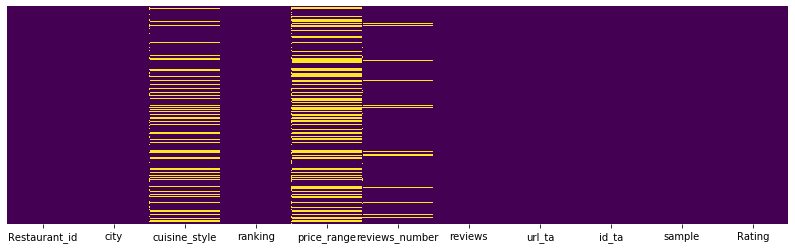

In [20]:
plt.figure(figsize=(14, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap = 'viridis')

## Осмотр и обработка данных и генерация новых признаков 

In [21]:
def analyse_numeric(datafr, column):
    '''Визуализирует распределение числовой переменной.
       Принимает параметрами DataFrame и строковое название столбца
       Печатает различные статистические показатели и строит гистограмму.'''
    count = datafr[column].count()
    mean = datafr[column].mean()
    std = datafr[column].std()
    median = datafr[column].median()
    perc25 = datafr[column].quantile(0.25)
    perc75 = datafr[column].quantile(0.75)
    IQR = perc75 - perc25
    range_min = datafr[column].min()
    range_max = datafr[column].max()
    margin = (range_max - range_min)/10
    range_start = range_min - margin
    range_stop = range_max + margin
    range_ = (range_start, range_stop)
    outliers = datafr[column].loc[(datafr[column] < perc25 - 1.5*IQR) | (datafr[column] > perc75 + 1.5*IQR)]

    print('Количество: {}, Среднее: {:.3f}, Стандартное отклонение: {:.3f}.'.format(count, mean, std))
    print('Минимум: {}, 25-й перцентиль: {}, Медиана: {}, 75-й перцентиль: {}, Максимум: {}, IQR: {}.'
          .format(range_min, perc25, median, perc75, range_max, IQR))
    print('Количество пропусков в столбце: ', pd.isnull(datafr[column]).sum())
    print('Границы выбросов: [{f}, {l}].'.format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR)
          , 'Количество выбросов: ', len(outliers))

    datafr[column].loc[datafr[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)] \
                  .hist(bins = 30, range = range_, label = 'В границах выбросов')
    outliers.hist(bins = 30, range = range_, label = 'Выбросы')
    
    plt.legend()

### Restaurant_id

In [22]:
df.Restaurant_id.nunique()

13094

### city

In [23]:
df_tmp = df.city.value_counts()
df_tmp

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: city, dtype: int64

Добавим столбец rests - количества ресторанов в городе

In [24]:
df['rests'] = df['city'].apply(lambda x: df_tmp[x])

Поработаем с популяциями городов. Добавим столбец population двумя разными способми: из внешнего датасета worldcities.csv с https://kaggle.com и из Википедии, https://en.wikipedia.org/wiki/List_of_cities_in_the_European_Union_by_population_within_city_limits и проверим, какой способ лучше.

Способ 1

In [25]:
# cities = pd.read_csv(DATA_DIR+'/worldcities.csv')
# cities.head()

In [26]:
# def get_population(str_city):
#     '''Возвращает популяцию города str_city'''
#     if str_city.lower() == 'oporto': # Такого названия нет в датасете cities
#         str_city = 'porto' # Зато есть такое
#     return cities[cities.city_ascii.str.lower() == str_city.lower()]['population'].max()

In [27]:
# df['population'] = df.city.apply(lambda x: get_population(x))

Способ 2

In [28]:
population_dict = {
    'London': 9304016,
    'Paris': 2140526,
    'Madrid': 3348536,
    'Barcelona': 1620343,
    'Berlin': 3748148,
    'Milan': 1404239,
    'Rome': 2856133,
    'Prague': 1324277,
    'Lisbon': 506654,
    'Vienna': 1911728,
    'Amsterdam': 873555,
    'Brussels': 1209000,
    'Hamburg': 1841179,
    'Munich': 1471508,
    'Lyon': 515695,
    'Stockholm': 974073,
    'Budapest': 1752286,
    'Warsaw': 1790658,
    'Dublin': 554554,
    'Copenhagen': 626508,
    'Athens': 664046,
    'Edinburgh': 524930,
    'Zurich': 415367,
    'Oporto': 237559,
    'Geneva': 201818,
    'Krakow': 779115,
    'Oslo': 693491,
    'Helsinki': 648042,
    'Bratislava': 432864,
    'Luxembourg': 613894,
    'Ljubljana': 292988
}

In [29]:
df['population'] = df['city'].map(population_dict)

"Пронормируем" столбец population (получим значения в тысячах жителей)

In [30]:
df['population'] = df['population'] / 1000

Добавим столбец rest_density плотности ресторанов в городе

In [31]:
df['rest_density'] = df.rests / df.population

Добавим признак capital - является ли город столицей

In [32]:
capitals = ['Paris', 'Stockholm', 'London', 'Berlin',
            'Bratislava', 'Vienna', 'Rome', 'Madrid',
            'Dublin', 'Brussels', 'Warsaw', 'Budapest', 'Copenhagen',
            'Amsterdam', 'Lisbon', 'Prague', 'Oslo',
            'Helsinki', 'Ljubljana', 'Athens', 'Luxembourg']
# Далее код закомментирован, так как признак ухудшает MAE
# df['capital'] = df['city'].apply(lambda x: x in capitals).astype('uint8')

Добавим признак country

In [33]:
countries_dict = {'Amsterdam': 'Netherlands',
             'Athens': 'Greece',
             'Barcelona': 'Spain',
             'Berlin': 'Germany',
             'Bratislava': 'Slovakia',
             'Brussels': 'Belgium',
             'Budapest': 'Hungary',
             'Copenhagen': 'Denmark',
             'Dublin': 'Ireland',
             'Edinburgh': 'UK',
             'Geneva': 'Switzerland',
             'Hamburg': 'Germany',
             'Helsinki': 'Finland',
             'Krakow': 'Poland',
             'Lisbon': 'Portugal',
             'Ljubljana': 'Slovenia',
             'London': 'UK',
             'Luxembourg': 'Luxembourg',
             'Lyon': 'France',
             'Madrid': 'Spain',
             'Milan': 'Italy',
             'Munich': 'Germany',
             'Oporto': 'Portugal',
             'Oslo': 'Norway',
             'Paris': 'France',
             'Prague': 'Czechia',
             'Rome': 'Italy',
             'Stockholm': 'Sweden',
             'Vienna': 'Austria',
             'Warsaw': 'Poland',
             'Zurich': 'Switzerland'}

df['country'] = df['city'].map(countries_dict)

Добавим dummies по странам

In [34]:
df = pd.get_dummies(df, columns=['country']) # , dummy_na=True # в странах пропусков нет
df.head(3)

,Restaurant_id,city,cuisine_style,ranking,price_range,reviews_number,reviews,url_ta,id_ta,sample,Rating,rests,population,rest_density,country_Austria,country_Belgium,country_Czechia,country_Denmark,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Ireland,country_Italy,country_Luxembourg,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Slovakia,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,country_UK
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,6108,2140.526,2.853504,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,475,648.042,0.732977,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,745,524.930,1.419237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Добавим dummies по городам

In [35]:
df = pd.concat([df, pd.get_dummies(df.city, prefix='city')], axis=1)
# #Альтернативный вариант кода:
# df = pd.get_dummies(df, columns=['city',]) # , dummy_na=True # в городах пропусков нет
df.head(3)

,Restaurant_id,city,cuisine_style,ranking,price_range,reviews_number,reviews,url_ta,id_ta,sample,Rating,rests,population,rest_density,country_Austria,country_Belgium,country_Czechia,country_Denmark,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Ireland,country_Italy,country_Luxembourg,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Slovakia,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,country_UK,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,6108,2140.526,2.853504,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,475,648.042,0.732977,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,745,524.930,1.419237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### cuisine_style

In [36]:
df.cuisine_style.value_counts()

['Italian']                                                                                                                            1332
['French']                                                                                                                             1019
['Spanish']                                                                                                                             860
['French', 'European']                                                                                                                  503
['Cafe']                                                                                                                                500
                                                                                                                                       ... 
['European', 'Scandinavian', 'Contemporary']                                                                                              1
['Italian', 'Pizza',

In [37]:
df['cuisine_style_isna'] = pd.isna(df.cuisine_style).astype('uint8')

In [38]:
df.cuisine_style.fillna('1', inplace=True)

In [39]:
df['cuisine'] = df.cuisine_style.str[1:-1].str.split(', ')

In [40]:
df['cuisine'].sample(5)

4909                                                    []
1504            ['Italian', 'Cafe', 'Vegetarian Friendly']
47968                                          ['Seafood']
28867                                          ['Spanish']
49359    ['Australian', 'Vegetarian Friendly', 'Vegan O...
Name: cuisine, dtype: object

In [41]:
len(df.explode('cuisine')['cuisine'].value_counts())

126

Создадим новый признак cuisines_number - количество кухонь, представленных рестораном

In [42]:
df['cuisines_number'] = df['cuisine'].apply( lambda x: 1.0 if len(x)==0 else float(len(x)))

### ranking

Количество: 50000, Среднее: 3664.428, Стандартное отклонение: 3700.092.
Минимум: 1.0, 25-й перцентиль: 972.0, Медиана: 2278.0, 75-й перцентиль: 5241.0, Максимум: 16444.0, IQR: 4269.0.
Количество пропусков в столбце:  0
Границы выбросов: [-5431.5, 11644.5]. Количество выбросов:  3075


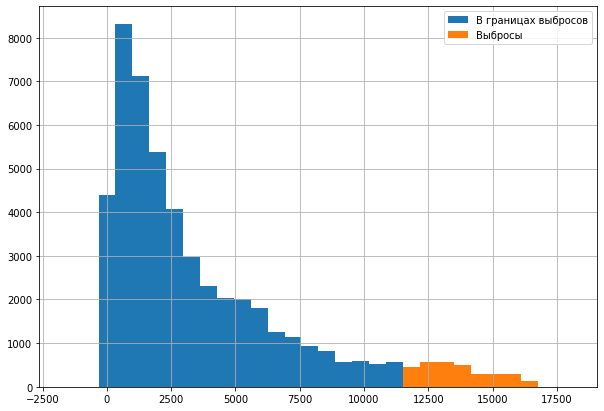

In [43]:
plt.rcParams['figure.figsize'] = (10,7)
analyse_numeric(df, 'ranking')

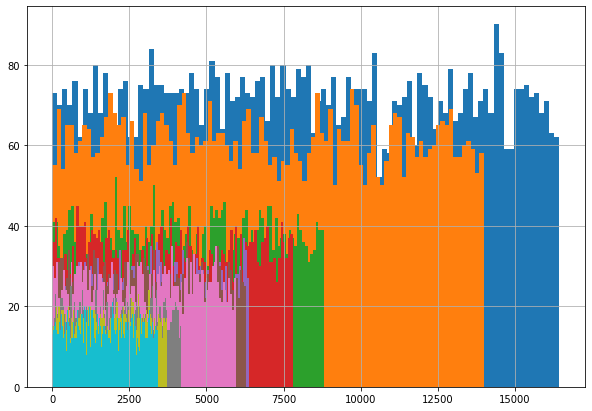

In [44]:
# Посмотрим на ranking в топ 10 городах
for x in (df['city'].value_counts())[:10].index:
    df['ranking'][df['city'] == x].hist(bins=100)
plt.show()

Получается, что ranking имеет равномерное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение

Создадим новый признак путем нормирования ranking к количеству ресторанов в городе

In [45]:
df['ranking_norm_rests'] = df.ranking / df.rests

Посмотрим распределение признака ranking относительно целевой переменной

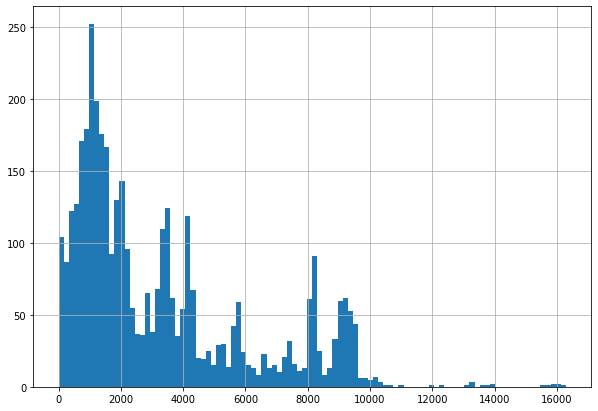

In [46]:
df['ranking'][df['Rating'] == 5].hist(bins=100)

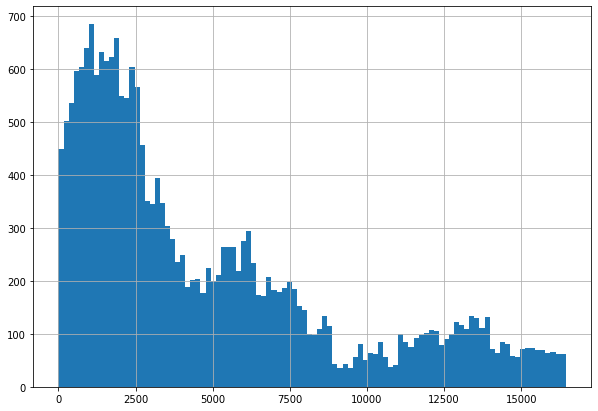

In [47]:
df['ranking'][df['Rating'] < 4].hist(bins=100)

> ### Rating

Количество: 50000, Среднее: 3.194, Стандартное отклонение: 1.705.
Минимум: 0.0, 25-й перцентиль: 3.0, Медиана: 4.0, 75-й перцентиль: 4.5, Максимум: 5.0, IQR: 1.5.
Количество пропусков в столбце:  0
Границы выбросов: [0.75, 6.75]. Количество выбросов:  10000


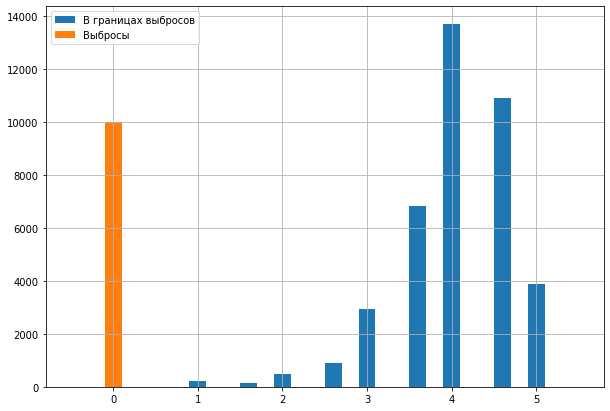

In [48]:
plt.rcParams['figure.figsize'] = (10,7)
analyse_numeric(df, 'Rating')

### price_range

In [49]:
df.price_range.value_counts(dropna=False)

$$ - $$$    23041
NaN         17361
$            7816
$$$$         1782
Name: price_range, dtype: int64

In [50]:
df['price_range_isna'] = pd.isna(df.price_range).astype('uint8')

In [51]:
# Нужно заполнить пропуски.
# Либо так:
#df['price_range_label'] = df.price_range.apply(lambda x: 1.0 if x=='$' else 2.5 if x=='$$ - $$$' else 4.0 if x=='$$$$' else np.nan)
# и заполним медианой по городам
#df.price_range_label = df.apply(lambda row: df[df.city==row.city].price_range_label.median() if pd.isna(row.price_range_label) \
#                                                                                     else row.price_range_label, axis=1)

# Либо так:
df['price_range_label'] = df.price_range.apply(lambda x: 2.5 if pd.isnull(x) else 1.0 if x=='$' else 2.5 if x=='$$ - $$$' else 4.0)

### reviews_number

Количество: 46800, Среднее: 124.471, Стандартное отклонение: 294.114.
Минимум: 2.0, 25-й перцентиль: 9.0, Медиана: 33.0, 75-й перцентиль: 115.0, Максимум: 9660.0, IQR: 106.0.
Количество пропусков в столбце:  3200
Границы выбросов: [-150.0, 274.0]. Количество выбросов:  5428


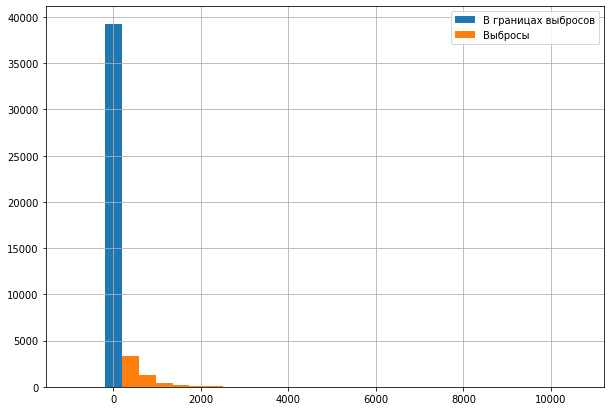

In [52]:
plt.rcParams['figure.figsize'] = (10,7)
analyse_numeric(df, 'reviews_number')

In [53]:
df['reviews_number_isna'] = pd.isna(df.reviews_number).astype('uint8')

In [54]:
# Заполним пропуски значением 0
df.reviews_number.fillna(0, inplace=True)

In [55]:
# Нормируем количество отзывов к населению города
df['reviews_number_norm'] = df.reviews_number / df.population

### reviews

In [56]:
df.reviews.value_counts(dropna=False)

[[], []]                                                                                                  8112
NaN                                                                                                          2
[['Thursday snack', 'Good value for money & good food!'], ['03/13/2017', '06/20/2016']]                      2
[['Good Lebanese food', 'Decent place'], ['07/19/2017', '03/17/2017']]                                       2
[['Very cozy!', 'Service rate: 1'], ['01/17/2016', '11/18/2015']]                                            2
                                                                                                          ... 
[['Nice location', 'Good food and service with seating by the...'], ['07/25/2017', '07/17/2017']]            1
[['Close to Eiffel Tower', 'Good value, Traditional Menu'], ['07/20/2016', '03/17/2013']]                    1
[['Good cocktails', 'Good but...'], ['10/21/2017', '10/02/2017']]                                            1
[

In [57]:
# Заполним пропуски
df.reviews.fillna('[[], []]', inplace=True)

In [58]:
df.reviews.value_counts(dropna=False)

[[], []]                                                                                                        8114
[['Happened to drop in', 'Right for a quick bite'], ['11/30/2016', '06/20/2015']]                                  2
[['Visited the rooftop bar', 'SIXTH FLOOR ROOFTOP BUT YOU CAN ONLY SEE O...'], ['06/27/2017', '10/31/2017']]       2
[['Excellent'], ['09/03/2015']]                                                                                    2
[['Great food, service and atmosphere', 'Decor and food'], ['11/06/2017', '10/22/2017']]                           2
                                                                                                                ... 
[['Nice location', 'Good food and service with seating by the...'], ['07/25/2017', '07/17/2017']]                  1
[['Close to Eiffel Tower', 'Good value, Traditional Menu'], ['07/20/2016', '03/17/2013']]                          1
[['Good cocktails', 'Good but...'], ['10/21/2017', '10/02/2017']

In [59]:
df['reviews_dates'] = df['reviews'].str.findall('\d+/\d+/\d+')
df[['reviews', 'reviews_dates']].head()

,reviews,reviews_dates
0,"[[], []]",[]
1,"[['Very good reviews!', 'Fine dining in Hakani...","[12/05/2017, 10/29/2017]"
2,"[['Better than the Links', 'Ivy Black'], ['12/...","[12/28/2017, 12/06/2017]"
3,"[['Most exquisite', 'Delicious and authentic']...","[12/06/2017, 11/22/2017]"
4,"[['Always the best in bratislava', 'Very good ...","[02/08/2018, 01/24/2018]"


In [60]:
df.reviews_dates.apply(lambda x: len(x)).value_counts()

2    36202
0     8114
1     5680
3        4
Name: reviews_dates, dtype: int64

In [61]:
df['reviews_dates_count'] = df.reviews_dates.apply(lambda x: len(x))

In [62]:
df[df.reviews_dates_count == 3]

,Restaurant_id,city,cuisine_style,ranking,price_range,reviews_number,reviews,url_ta,id_ta,sample,Rating,rests,population,rest_density,country_Austria,country_Belgium,country_Czechia,country_Denmark,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Ireland,country_Italy,country_Luxembourg,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Slovakia,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,country_UK,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,cuisine_style_isna,cuisine,cuisines_number,ranking_norm_rests,price_range_isna,price_range_label,reviews_number_isna,reviews_number_norm,reviews_dates,reviews_dates_count
2221,id_2221,London,"['Lebanese', 'Fast Food', 'Mediterranean', 'Tu...",3552.0,$,202.0,"[['We visited 21/10/17', 'Best Kebab in London...",/Restaurant_Review-g186338-d1009460-Reviews-Ta...,d1009460,0,0.0,7193,9304.016,0.773107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"['Lebanese', 'Fast Food', 'Mediterranean', 'Tu...",6.0,0.493813,0,1.0,0,0.021711,"[21/10/17, 12/22/2017, 10/19/2017]",3
3809,id_3809,Stockholm,"['European', 'Swedish', 'Scandinavian']",956.0,NaN,9.0,"[['Good Museum Cafeteria', 'Lunch 30/5/2017'],...",/Restaurant_Review-g189852-d12318961-Reviews-N...,d12318961,0,0.0,1033,974.073,1.060495,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,"['European', 'Swedish', 'Scandinavian']",3.0,0.925460,1,2.5,0,0.009240,"[30/5/2017, 04/13/2017, 05/30/2017]",3
19254,id_12965,London,"['Cafe', 'French']",12975.0,$$ - $$$,31.0,"[['The desserts arcade !', 'Visit today 3/1/20...",/Restaurant_Review-g186338-d1017372-Reviews-Ma...,d1017372,1,3.5,7193,9304.016,0.773107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"['Cafe', 'French']",2.0,1.803837,0,2.5,0,0.003332,"[3/1/2017, 06/02/2017, 01/03/2017]",3
33348,id_450,Geneva,"['French', 'European']",453.0,$$ - $$$,48.0,"[['lunch 29/9/2016', 'Unplanned Great Dinner']...",/Restaurant_Review-g188057-d2706773-Reviews-Le...,d2706773,1,4.0,590,201.818,2.923426,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"['French', 'European']",2.0,0.767797,0,2.5,0,0.237838,"[29/9/2016, 09/30/2016, 08/25/2016]",3


In [63]:
df['review1_date'] = df.reviews_dates.apply(lambda x: x[1] if len(x)==3 else x[0] if len(x)>0 else None)

In [64]:
df['review2_date'] = df.reviews_dates.apply(lambda x: x[2] if len(x)==3 else x[1] if len(x)>1 else None)

In [65]:
df['review1_date_d'] = df.review1_date.apply(lambda x: None if pd.isna(x) else datetime.strptime(x, '%m/%d/%Y'))

In [66]:
df['review2_date_d'] = df.review2_date.apply(lambda x: None if pd.isna(x) else datetime.strptime(x, '%m/%d/%Y'))

In [67]:
df[['review1_date_d', 'review2_date_d']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   review1_date_d  41886 non-null  datetime64[ns]
 1   review2_date_d  36206 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 781.4 KB


Создадим новый признак - количество дней между отзывами

In [68]:
df['days_between'] = ((df.review1_date_d - df.review2_date_d).dt.days)#abs

Количество: 36206, Среднее: 124.731, Стандартное отклонение: 233.009.
Минимум: -362.0, 25-й перцентиль: 13.0, Медиана: 55.0, 75-й перцентиль: 157.0, Максимум: 3296.0, IQR: 144.0.
Количество пропусков в столбце:  13794
Границы выбросов: [-203.0, 373.0]. Количество выбросов:  3859


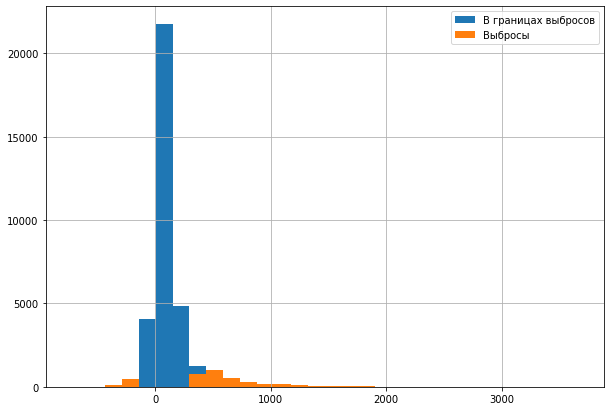

In [69]:
plt.rcParams['figure.figsize'] = (10,7)
analyse_numeric(df, 'days_between')

In [70]:
# Заполним пропуски значением 0
df.days_between.fillna(0, inplace=True)

Создадим новый признак - количество дней между последним отзывом и сегодняшней датой

In [71]:
df['days_to_today'] = ((date_today - df.review1_date_d).dt.days)

Количество: 41886, Среднее: 1167.746, Стандартное отклонение: 361.495.
Минимум: 870.0, 25-й перцентиль: 952.0, Медиана: 1038.0, 75-й перцентиль: 1225.0, Максимум: 5929.0, IQR: 273.0.
Количество пропусков в столбце:  8114
Границы выбросов: [542.5, 1634.5]. Количество выбросов:  3665


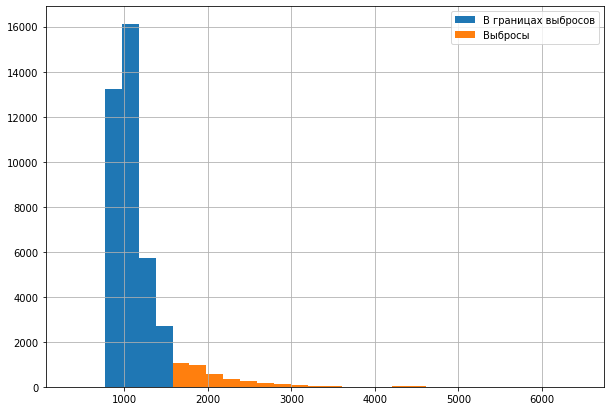

In [72]:
plt.rcParams['figure.figsize'] = (10,7)
analyse_numeric(df, 'days_to_today')

In [73]:
# Заполним пропуски
df.days_to_today.fillna(df.days_to_today.median(), inplace=True)

### url_ta

In [74]:
df.url_ta.value_counts()

/Restaurant_Review-g187514-d793170-Reviews-Caripen_Bistro-Madrid.html                                               2
/Restaurant_Review-g274856-d3396817-Reviews-Restauracja_Olive_Garden-Warsaw_Mazovia_Province_Central_Poland.html    2
/Restaurant_Review-g187514-d11999956-Reviews-SugarCane_Madrid-Madrid.html                                           2
/Restaurant_Review-g187514-d4914988-Reviews-Xiang_Asia_Restaurant-Madrid.html                                       2
/Restaurant_Review-g187514-d2669414-Reviews-Vips-Madrid.html                                                        2
                                                                                                                   ..
/Restaurant_Review-g187497-d5011008-Reviews-Hofmann_La_Seca_Terrassa-Barcelona_Catalonia.html                       1
/Restaurant_Review-g187331-d1340145-Reviews-La_Locanda-Hamburg.html                                                 1
/Restaurant_Review-g187331-d2719884-Reviews-La_Fortuna-H

Этот признак просто потом удалим

### id_ta

In [75]:
df.id_ta.value_counts()

d11999956    2
d7342803     2
d7827387     2
d4914988     2
d11698990    2
            ..
d7082922     1
d10074247    1
d10507352    1
d7322279     1
d4769559     1
Name: id_ta, Length: 49963, dtype: int64

### Преобразуем id_ta в числа (будет новый признак):

In [76]:
df['id_ta_num'] = df['id_ta'].str[1:].astype('int64')

### Корреляция признаков

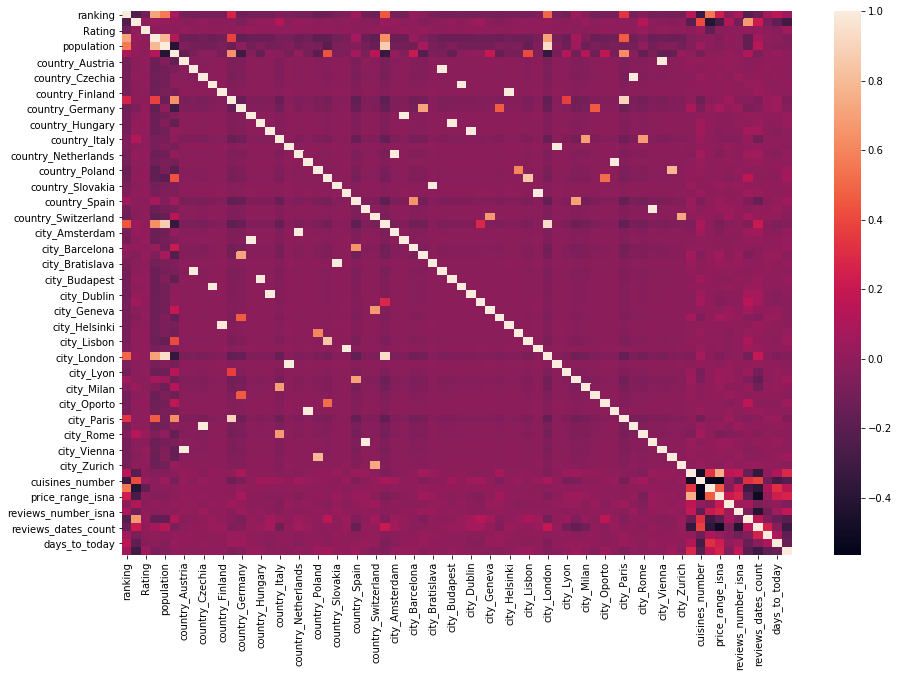

In [77]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.drop(['sample'], axis=1).corr(),)

### Попробуем текстовую классификацию. Сгенерируем бинарные признаки по словам, входящим в тексты отзывов в поле **reviews**

In [78]:
#import string
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [79]:
# pd.options.mode.chained_assignment = None

In [80]:
def stop_words_remover(text):
    '''Предобработка текстов: удаление дополнительных стоп-слов (кроме stop_words='english')'''
    
    text = text.lower() 
    
    text = re.sub(r'\b\d+\b', '', text) # Удаляем цифры
    
    singles = [word for word in text.split()]
    text = ' '.join(singles)
        
    #Удаление незначимых слов, а также, названий городов и стран
    stw = ['a', 'at', 'on', 'of', 'and', 'or', 'in', 'for', 'at', 'empty', 'cuisine', 'food' ]
    stw.extend(['restaura', 'restauran', 'restaurant', 'restaurante', 'restaurants', 'resto', 'restuarant',
                'restau', 'restaur', 'resturant'])
    
    stw.extend(list(x.lower() for x in countries_dict.keys()))
    stw.extend(list(x.lower() for x in countries_dict.values()))
    
    remove = r'\b(' + '|'.join(stw) + r')\b'  
    text = re.sub(remove, ' ', text)
    
    return  text

In [81]:
english_stemmer = SnowballStemmer("english")
class StemmedTfidfVectorizer(TfidfVectorizer):

    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        #return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))
        return lambda doc: (w for w in analyzer(doc))

vect_tfidf = StemmedTfidfVectorizer(min_df=10
                                    ,max_df=0.7
                                    ,stop_words='english'
                                    ,ngram_range=(1, 1)
                                    #,decode_error='ignore'
                                    ,strip_accents='ascii' #'unicode', 'ascii', None
                                    #,preprocessor=stop_words_remover
                                   )
print(vect_tfidf)

StemmedTfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                       dtype=<class 'numpy.float64'>, encoding='utf-8',
                       input='content', lowercase=True, max_df=0.7,
                       max_features=None, min_df=10, ngram_range=(1, 1),
                       norm='l2', preprocessor=None, smooth_idf=True,
                       stop_words='english', strip_accents='ascii',
                       sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                       tokenizer=None, use_idf=True, vocabulary=None)


In [82]:
df.reviews = df.reviews.apply(lambda s: stop_words_remover(s))

In [83]:
# Применим векторизатор
X_tfidf = vect_tfidf.fit_transform(df.reviews)

In [84]:
num_samples_tfidf, num_features_tfidf = X_tfidf.shape
print("#samples: %d, #features: %d" % (num_samples_tfidf,  num_features_tfidf))
print(len(vect_tfidf.get_feature_names()))
print(vect_tfidf.get_feature_names())

#samples: 50000, #features: 1545
1545
['1st', '2nd', 'absolute', 'absolutely', 'acceptable', 'accident', 'accommodating', 'acropolis', 'actually', 'addition', 'address', 'adequate', 'adorable', 'affordable', 'african', 'afternoon', 'air', 'airport', 'al', 'alcohol', 'ale', 'alright', 'alternative', 'amazing', 'amazingly', 'ambiance', 'ambience', 'ambient', 'american', 'anniversary', 'anymore', 'aperitivo', 'appalling', 'apple', 'ar', 'arabic', 'area', 'arepas', 'argentinian', 'arrogant', 'art', 'asia', 'asian', 'ask', 'ate', 'athmosphere', 'atm', 'atmo', 'atmos', 'atmosp', 'atmosph', 'atmosphe', 'atmospher', 'atmosphere', 'atmospheric', 'attention', 'attentive', 'attitude', 'attractive', 'au', 'austrian', 'authentic', 'available', 'average', 'avoid', 'away', 'awesome', 'awful', 'ba', 'bacon', 'bad', 'bagel', 'bagels', 'baguette', 'baked', 'bakery', 'balkan', 'bao', 'bar', 'bargain', 'barman', 'bars', 'bartender', 'basement', 'basic', 'bavarian', 'bbq', 'bcn', 'beach', 'beat', 'beaten',

In [85]:
print(X_tfidf[1])
print(X_tfidf.toarray().shape)

  (0, 351)	0.5013083779074269
  (0, 500)	0.5195986726406554
  (0, 1113)	0.6586506744609748
  (0, 578)	0.21186415143198864
(50000, 1545)


In [86]:
df.reviews[1]

"[['very good reviews!', 'fine dining   hakaniemi'], ['//', '//']]"

In [87]:
features_matrix = X_tfidf.toarray()

Добавляем признаки на основе слов в отзывах со значением частоты встречаемости слова в конкретном отзыве

In [88]:
for i in range(features_matrix.shape[1]):
    feat_to_add = str(i) + '_f'
    df[feat_to_add] = features_matrix[:,i]

### Теперь готовим данные для использования в моделе

Удаляем ненужные признаки

In [89]:
df_preproc = df.drop(['Restaurant_id', 'cuisine_style', 'price_range', 'url_ta', 'id_ta',
                      'cuisine', 'reviews_dates', 'review1_date', 'review2_date', 'review1_date_d',
                      'review2_date_d', 'reviews_dates_count', 'rests', 'population', 'reviews', 'city'], axis = 1)

In [90]:
df_preproc.sample(3)

,ranking,reviews_number,sample,Rating,rest_density,country_Austria,country_Belgium,country_Czechia,country_Denmark,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Ireland,country_Italy,country_Luxembourg,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Slovakia,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,country_UK,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,...,1495_f,1496_f,1497_f,1498_f,1499_f,1500_f,1501_f,1502_f,1503_f,1504_f,1505_f,1506_f,1507_f,1508_f,1509_f,1510_f,1511_f,1512_f,1513_f,1514_f,1515_f,1516_f,1517_f,1518_f,1519_f,1520_f,1521_f,1522_f,1523_f,1524_f,1525_f,1526_f,1527_f,1528_f,1529_f,1530_f,1531_f,1532_f,1533_f,1534_f,1535_f,1536_f,1537_f,1538_f,1539_f,1540_f,1541_f,1542_f,1543_f,1544_f
23894,374.0,33.0,1,4.0,0.644152,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48751,2480.0,113.0,1,4.0,2.853504,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17645,2172.0,42.0,1,4.0,0.721690,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 1613 entries, ranking to 1544_f
dtypes: float64(1555), int64(2), uint8(56)
memory usage: 596.6 MB


Разделим данные по признаку **sample** на тренировочные и тестовые

In [92]:
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн для валидации. 
Это поможет нам оценить, насколько хорошо работает наша модель до отправки submission на kaggle.**

In [93]:
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [94]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 1612), (40000, 1612), (40000, 1611), (32000, 1611), (8000, 1611))

## Model

In [95]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [96]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [97]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)


# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [98]:
# # Обучаем модель на полном тренировочном наборе данных
# model.fit(X, y)

In [99]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
y_pred_rand = (y_pred*2).round()/2
print('MAE on rand:', metrics.mean_absolute_error(y_test, y_pred_rand))

MAE: 0.194629375
MAE on rand: 0.1635625


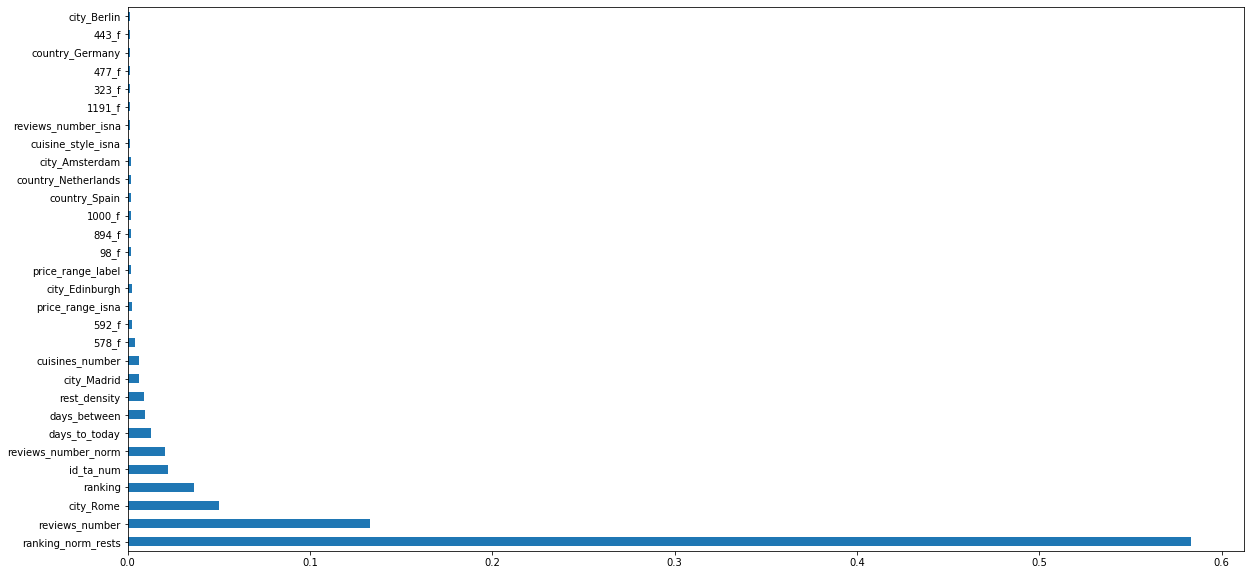

In [100]:
# Выведем самые важные признаки для RandomForestRegressor
plt.rcParams['figure.figsize'] = (20,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

# Submission

In [101]:
test_data.sample(10)

,ranking,reviews_number,Rating,rest_density,country_Austria,country_Belgium,country_Czechia,country_Denmark,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Ireland,country_Italy,country_Luxembourg,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Slovakia,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,country_UK,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,...,1495_f,1496_f,1497_f,1498_f,1499_f,1500_f,1501_f,1502_f,1503_f,1504_f,1505_f,1506_f,1507_f,1508_f,1509_f,1510_f,1511_f,1512_f,1513_f,1514_f,1515_f,1516_f,1517_f,1518_f,1519_f,1520_f,1521_f,1522_f,1523_f,1524_f,1525_f,1526_f,1527_f,1528_f,1529_f,1530_f,1531_f,1532_f,1533_f,1534_f,1535_f,1536_f,1537_f,1538_f,1539_f,1540_f,1541_f,1542_f,1543_f,1544_f
1563,7132.0,29.0,0.0,0.773107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4112,1144.0,41.0,0.0,1.918477,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9116,354.0,39.0,0.0,0.711063,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8232,6655.0,11.0,0.0,1.138707,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9469,4836.0,101.0,0.0,1.138707,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6391,932.0,42.0,0.0,0.721690,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4696,434.0,298.0,0.0,2.853504,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5263,1069.0,184.0,0.0,1.918477,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
400,1527.0,52.0,0.0,1.138707,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
686

In [102]:
test_data = test_data.drop(['Rating'], axis=1)

In [103]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [104]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [105]:
predict_submission = (predict_submission*2).round()/2

In [106]:
predict_submission

array([3. , 4. , 4. , ..., 3. , 4.5, 4. ])

In [107]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.0
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,2.0
8,id_8,4.0
9,id_9,4.5
